In [29]:
import pandas as pd
import numpy as np
import os
import sys

fileDir = os.path.dirname(os.path.realpath('__file__'))
print(fileDir)
file = "../../../Received_data_for_tests.csv"

/Users/mathiasmarkvardsen/bachelor/IOTunderwater/Code/dsp/plotting & data handling


In [30]:
df = pd.read_csv(file, sep=',')
df.tail(2)

,ID,Bitrate,Carrier Frequency,Original Message,Decoded without bandpass,Hamming Dist without bandpass,Decoded with bandpass,Hamming Dist with bandpass,Encoding,Transmitter,Container,Speaker depth,Distance to speaker,Test description,Original message in bits,Data bits without bandpass,Data bits with bandpass
15,2511c487-c2e7-4ec3-b655-b15b5aadcf32,100,6000,Hello_there,Hello_there,0.0,Hello_t`%re,2.0,No Encoding,ESP,plastic,200,600,EXAMPLE 2: test 2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...","[[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...","[[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,..."
16,1b7c3894-23bf-441c-b4cb-b1686caa48e4,100,6000,Hello_there,No preamble found,NaN,No preamble found,NaN,No Encoding,ESP,plastic,200,600,EXAMPLE 2: test 2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...",NaN,NaN


In [31]:
# Display the columns to verify we have test description and bits data
print("Available columns:")
print(df.columns.tolist())

# Basic statistics about the dataset
print(f"Total number of tests: {len(df)}")
print(f"Number of unique test descriptions: {df['Test description'].nunique()}")

# Group by test description
grouped = df.groupby('Test description')

# Function to analyze bit flips between original and decoded bits
def analyze_bit_flips(original, decoded):
    # Convert to strings if they aren't already
    original = str(original)
    decoded = str(decoded)
    
    # Make strings equal length by padding
    max_len = max(len(original), len(decoded))
    original = original.zfill(max_len)
    decoded = decoded.zfill(max_len)
    
    # Compare bits
    flips = []
    for i, (orig, dec) in enumerate(zip(original, decoded)):
        if orig != dec:
            flips.append((i, orig, dec))
    
    return flips

# Create a summary dataframe for bit flip analysis
results = []

for name, group in grouped:
    # Count total tests in this group
    test_count = len(group)
    
    # Analyze without bandpass
    total_flips_no_bp = 0
    flip_positions_no_bp = {}
    
    # Analyze with bandpass
    total_flips_with_bp = 0
    flip_positions_with_bp = {}
    
    for _, row in group.iterrows():
        # Without bandpass
        if 'Original bits' in df.columns and 'Decoded bits without bandpass' in df.columns:
            flips = analyze_bit_flips(row['Original bits'], row['Decoded bits without bandpass'])
            total_flips_no_bp += len(flips)
            for pos, orig, dec in flips:
                key = f"Pos {pos}: {orig}->{dec}"
                flip_positions_no_bp[key] = flip_positions_no_bp.get(key, 0) + 1
        
        # With bandpass
        if 'Original bits' in df.columns and 'Decoded bits with bandpass' in df.columns:
            flips = analyze_bit_flips(row['Original bits'], row['Decoded bits with bandpass'])
            total_flips_with_bp += len(flips)
            for pos, orig, dec in flips:
                key = f"Pos {pos}: {orig}->{dec}"
                flip_positions_with_bp[key] = flip_positions_with_bp.get(key, 0) + 1
    
    # Calculate averages and add to results
    avg_flips_no_bp = total_flips_no_bp / test_count if test_count > 0 else 0
    avg_flips_with_bp = total_flips_with_bp / test_count if test_count > 0 else 0
    
    # Get most common flip patterns
    common_flips_no_bp = sorted(flip_positions_no_bp.items(), key=lambda x: x[1], reverse=True)[:5]
    common_flips_with_bp = sorted(flip_positions_with_bp.items(), key=lambda x: x[1], reverse=True)[:5]
    
    results.append({
        'Test Description': name,
        'Test Count': test_count,
        'Avg Flips No Bandpass': avg_flips_no_bp,
        'Avg Flips With Bandpass': avg_flips_with_bp,
        'Common Flips No Bandpass': common_flips_no_bp,
        'Common Flips With Bandpass': common_flips_with_bp
    })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df

Available columns:
['ID', 'Bitrate', 'Carrier Frequency', 'Original Message', 'Decoded without bandpass', 'Hamming Dist without bandpass', 'Decoded with bandpass', 'Hamming Dist with bandpass', 'Encoding', 'Transmitter', 'Container', 'Speaker depth', 'Distance to speaker', 'Test description', 'Original message in bits', 'Data bits without bandpass', 'Data bits with bandpass']
Total number of tests: 17
Number of unique test descriptions: 2


,Test Description,Test Count,Avg Flips No Bandpass,Avg Flips With Bandpass,Common Flips No Bandpass,Common Flips With Bandpass
0,EXAMPLE 2: test 2,10,0.0,0.0,[],[]
1,EXAMPLE : This test aims to create a function ...,7,0.0,0.0,[],[]


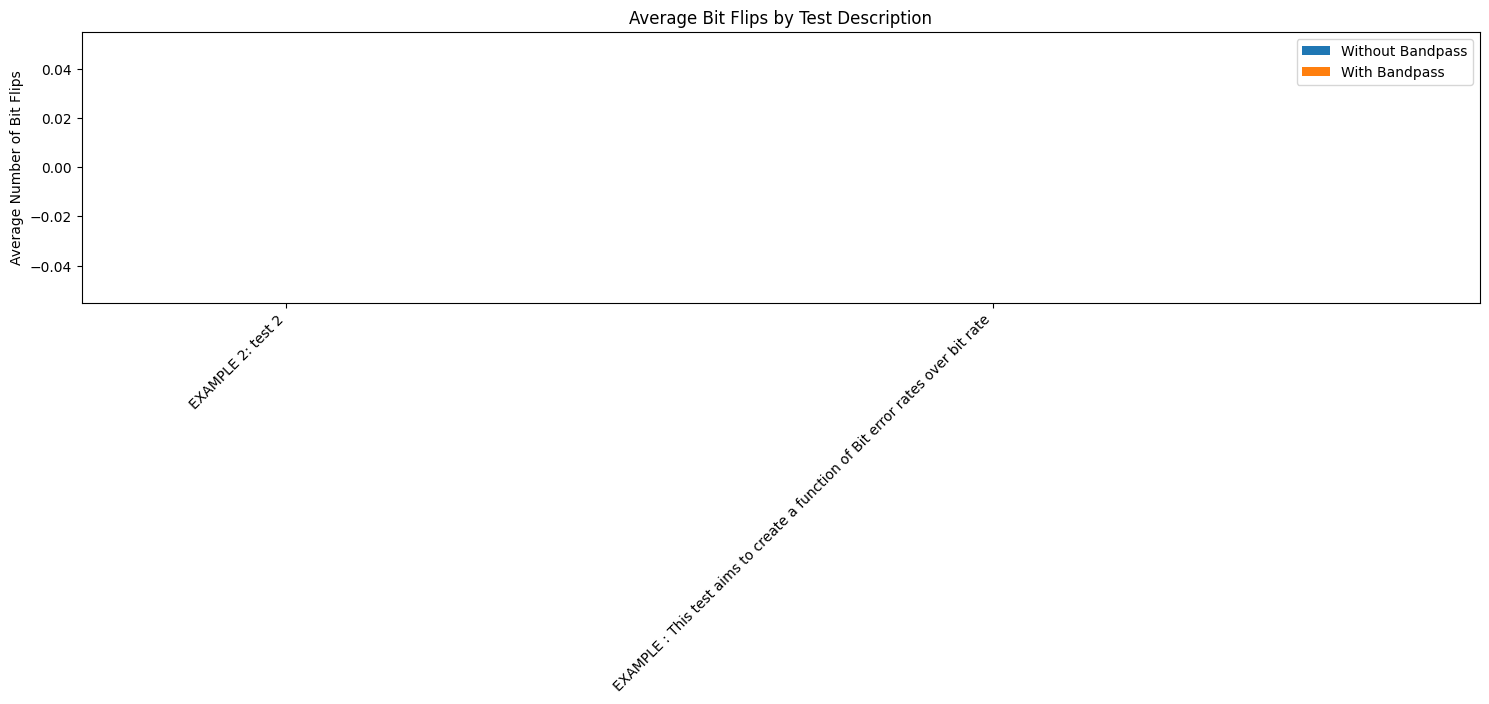

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(15, 10))

# Plot average bit flips by test description
plt.subplot(2, 1, 1)
x = range(len(results_df))
plt.bar(x, results_df['Avg Flips No Bandpass'], width=0.4, align='edge', label='Without Bandpass')
plt.bar([i+0.4 for i in x], results_df['Avg Flips With Bandpass'], width=0.4, align='edge', label='With Bandpass')
plt.xticks([i+0.2 for i in x], results_df['Test Description'], rotation=45, ha='right')
plt.ylabel('Average Number of Bit Flips')
plt.title('Average Bit Flips by Test Description')
plt.legend()
plt.tight_layout()

# Create a heatmap to visualize bit error patterns for a specific test
if len(grouped) > 0:
    # Select a test description to visualize (you can change this to any group)
    test_desc = results_df['Test Description'].iloc[0]
    group_data = grouped.get_group(test_desc)
    
    if 'Original bits' in df.columns and 'Decoded bits without bandpass' in df.columns:
        plt.subplot(2, 1, 2)
        
        # Create a binary matrix of bit flips (1 = flip, 0 = no flip)
        max_len = max(group_data['Original bits'].apply(len).max(), 
                      group_data['Decoded bits without bandpass'].apply(len).max())
        
        flip_matrix = np.zeros((len(group_data), max_len))
        
        for i, (_, row) in enumerate(group_data.iterrows()):
            original = str(row['Original bits']).zfill(max_len)
            decoded = str(row['Decoded bits without bandpass']).zfill(max_len)
            
            for j, (o, d) in enumerate(zip(original, decoded)):
                flip_matrix[i, j] = 1 if o != d else 0
        
        sns.heatmap(flip_matrix, cmap='YlOrRd', cbar_kws={'label': 'Bit Flip (1=Flipped)'})
        plt.xlabel('Bit Position')
        plt.ylabel('Test Sample')
        plt.title(f'Bit Flip Pattern for Test Description: {test_desc}')

plt.tight_layout()
plt.show()

# Calculate bit error rate by position across all tests
if 'Original bits' in df.columns:
    # Determine the maximum bit length across all samples
    max_bit_len = 0
    if 'Original bits' in df.columns:
        max_bit_len = max(max_bit_len, df['Original bits'].apply(lambda x: len(str(x))).max())
    
    # Initialize arrays for counting errors by position
    errors_by_pos_no_bp = np.zeros(max_bit_len)
    errors_by_pos_with_bp = np.zeros(max_bit_len)
    total_by_pos = np.zeros(max_bit_len)
    
    # Count errors by bit position
    for _, row in df.iterrows():
        if 'Original bits' in df.columns:
            original = str(row['Original bits']).zfill(max_bit_len)
            
            # Without bandpass
            if 'Decoded bits without bandpass' in df.columns:
                decoded = str(row['Decoded bits without bandpass']).zfill(max_bit_len)
                for i, (o, d) in enumerate(zip(original, decoded)):
                    if i < max_bit_len:
                        total_by_pos[i] += 1
                        errors_by_pos_no_bp[i] += (1 if o != d else 0)
            
            # With bandpass
            if 'Decoded bits with bandpass' in df.columns:
                decoded = str(row['Decoded bits with bandpass']).zfill(max_bit_len)
                for i, (o, d) in enumerate(zip(original, decoded)):
                    if i < max_bit_len:
                        errors_by_pos_with_bp[i] += (1 if o != d else 0)
    
    # Calculate error rates
    error_rate_no_bp = np.divide(errors_by_pos_no_bp, total_by_pos, where=total_by_pos>0)
    error_rate_with_bp = np.divide(errors_by_pos_with_bp, total_by_pos, where=total_by_pos>0)
    
    # Plot error rates by bit position
    plt.figure(figsize=(15, 6))
    plt.plot(range(max_bit_len), error_rate_no_bp, 'o-', label='Without Bandpass')
    plt.plot(range(max_bit_len), error_rate_with_bp, 'o-', label='With Bandpass')
    plt.xlabel('Bit Position')
    plt.ylabel('Error Rate')
    plt.title('Bit Error Rate by Position')
    plt.legend()
    plt.grid(True)
    plt.show()